# Sparse Nonlinear Least Squares

We're interested in nonlinear least squares problems of the form

$$min_x \|f(x)\|_2^2,$$

but prefer $x$ to be sparse. I proposed to tackle this by a reparametrization trick. I'm interested to know if prox methods could do this better, especially if they're adapted to second order methods. To this end, I'm going to try SKGLM on a linear version of the above, with $f(x) = Ax$.

In [13]:
import dataclasses as dc

import numpy as np
import matplotlib.pylab as plt

@dc.dataclass
class LASSOProblem:
    A: np.ndarray = None
    b: np.ndarray = None
    lam: float = 0.

    @classmethod
    def random_problem(cls, rows=500, cols=1000) -> 'LASSOProblem':
        return cls(
            A=np.random.randn(rows, cols),
            b=np.random.randn(rows),
            lam=1.
        )

lasso_problem = LASSOProblem.random_problem()

# Sparsity by Reparametrizing as Nonlinear Least Squares

Regularizing a regression problem with a p-norm with $0<p\leq 1$ causes some of the the entries of the solution to go to zero. The smaller $p$ is, the more aggresive the sparisification.

Let's solve

$$\min_x \|A x - b\|_2^2 + \lambda \|x\|_{2/3}^{2/3}.$$

To do that, introduce the change of variables

$$x = y^3,$$

and rewrite the optimization problem as

$$\min_y \|A y^3 - b\|_2^2 + \lambda \|y\|_2^2.$$

In [14]:
%%time

import scipy.optimize

def LASSO_reparametrized_nonlinear_least_squares(lasso: LASSOProblem) -> np.ndarray:
    def func(y):
        return np.hstack((
            lasso.A.dot(y**3) - lasso.b,
            np.sqrt(lasso.lam) * y
        ))

    def dfunc(y):
        return np.vstack((
          3 * lasso.A * y[None, :]**2,
          np.sqrt(lasso.lam) * np.eye(len(y))
        ))


    x0 = np.linalg.lstsq(lasso.A, lasso.b)[0]
    r = scipy.optimize.least_squares(
      func, x0, jac=dfunc, method='lm',
      max_nfev=100,
    )

    return r.x**3

x_reparametrized_nonlinear_least_squares = LASSO_reparametrized_nonlinear_least_squares(lasso_problem)

/home/qbe/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


CPU times: user 48.9 s, sys: 324 ms, total: 49.2 s
Wall time: 49.2 s


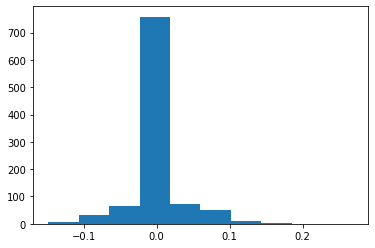

In [15]:
plt.hist(x_reparametrized_nonlinear_least_squares);

# SKGML

SKGLM is a package for sparse linear regression.

In [16]:
%%time

import skglm

def LASSO_skglm(lasso: LASSOProblem) -> np.ndarray:
    model = skglm.GeneralizedLinearEstimator(
        datafit=skglm.datafits.Quadratic(),
        penalty=skglm.penalties.L2_3(lasso.lam / len(lasso.b)),
        solver=skglm.solvers.AndersonCD(
            tol=1e-12, verbose=True, fit_intercept=False,
            ws_strategy="fixpoint"
        ),
    )

    model.fit(lasso.A, lasso.b)

    return model.coef_

x_skglm = LASSO_skglm(lasso_problem)

Stopping criterion max violation: 1.37e-01
Iteration 1, 10 feats in subpb.
Stopping criterion max violation: 1.14e-01
Iteration 2, 20 feats in subpb.
Stopping criterion max violation: 1.05e-01
Iteration 3, 40 feats in subpb.
Stopping criterion max violation: 9.25e-02
Iteration 4, 80 feats in subpb.
Stopping criterion max violation: 7.92e-02
Iteration 5, 158 feats in subpb.
Stopping criterion max violation: 5.52e-02
Iteration 6, 284 feats in subpb.
Stopping criterion max violation: 3.23e-02
Iteration 7, 448 feats in subpb.
Stopping criterion max violation: 1.72e-02
Iteration 8, 564 feats in subpb.
Stopping criterion max violation: 1.52e-02
Iteration 9, 546 feats in subpb.
Stopping criterion max violation: 1.51e-02
Iteration 10, 554 feats in subpb.
Stopping criterion max violation: 7.91e-03
Iteration 11, 560 feats in subpb.
Stopping criterion max violation: 7.17e-03
Iteration 12, 546 feats in subpb.
Stopping criterion max violation: 8.78e-03
Iteration 13, 540 feats in subpb.
Stopping cri

In [17]:
x_skglm

array([ 0.        ,  0.        ,  0.        ,  0.11347698,  0.06233511,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.06605469,  0.        , -0.10549047,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.07464178,  0.        ,  0.        ,  0.        ,  0.        ,
        0.03284071,  0.18074089,  0.        ,  0.18739028,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.04888014,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.12119641, -0.04583394, -0.01347527,
        0.        ,  0.        ,  0.        ,  0.03858028,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , -0.03069336, -0.0235448 ,  0.        ,  0.        ,
        0.        , -0.05026502,  0.        ,  0.09933852,  0.07886203,
        0.        ,  0.03554145,  0.        ,  0.        , -0.01

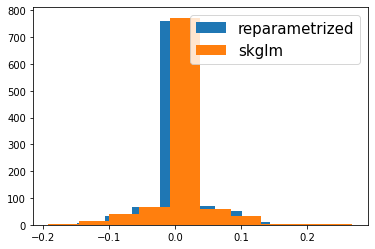

In [18]:
plt.hist(x_reparametrized_nonlinear_least_squares, label='reparametrized')
plt.hist(x_skglm, label='skglm');
plt.legend(fontsize=15)
plt.show()
